In [1]:
import pickle
import numpy as np
import copy
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from datetime import datetime
import math as m

import joblib

In [2]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

In [3]:
# Carregar dados
with open('df_pedidos_baixados_2020_a_2023_processado.pkl', 'rb') as file:
    dados = pickle.load(file)
dados = dados[dados.Ano>=2021]

In [4]:
dados.shape

(146082, 8)

In [5]:
percentual_de_recorte = 75  # Ajustar aqui para recortar
#oportunidade de melhoria: nao descartar esses dados, usar para amostrar os "outros"
recorte_amostral = dados.query(f'PercentualAcumulado_2020_2023 <= {percentual_de_recorte}')\
                        .sort_values(by=['PercentualAcumulado_2020_2023']).copy()
print(recorte_amostral.OrgaoDestinatario.unique().shape)

percentual_limite = 70 # Ajustar aqui para definir os "Outros" (percentual_de_recorte-percentual_limite)
recorte_amostral['Orgao_alvo'] = recorte_amostral.apply(lambda row: row['OrgaoDestinatario'] 
                               if row['PercentualAcumulado_2020_2023'] <= percentual_limite else 'Outros', axis=1)
recorte_amostral = recorte_amostral[['Orgao_alvo', 'Mês', 'Dia da Semana', 'DetalhamentoSolicitacao']]
print(recorte_amostral.shape)
print(recorte_amostral.Orgao_alvo.unique().shape) # qtd de classes

(61,)
(111344, 4)
(47,)


In [6]:
# Vetorização TF-IDF
max_features_tfidf=14000
max_df=0.1
min_df=0.0001
ngram_range=(1,1)
vectorizer = TfidfVectorizer(max_features=max_features_tfidf, max_df=max_df, min_df=min_df, ngram_range=ngram_range)
X_tfidf = vectorizer.fit_transform(recorte_amostral['DetalhamentoSolicitacao'])


# Codificação dos rótulos
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(recorte_amostral['Orgao_alvo'])


y_encoded = torch.tensor(y_encoded, dtype=torch.long)
y_encoded = nn.functional.one_hot(y_encoded) 

# Codificação dos parâmetros adicionais: mês e dia da semana
onehot_encoder = OneHotEncoder()
mes_dia_semana_encoded = onehot_encoder.fit_transform(recorte_amostral[['Mês', 'Dia da Semana']])


print(X_tfidf.shape)

(111344, 13125)


joblib.dump(vectorizer, 'tfidf_vectorizer.sav')
joblib.dump(label_encoder, 'label_encoder.sav')
joblib.dump(onehot_encoder, 'onehot_encoder.sav')

vectorizer = joblib.load('tfidf_vectorizer.sav')
label_encoder = joblib.load('label_encoder.sav')
onehot_encoder = joblib.load('onehot_encoder.sav')


In [7]:
with open('df_pedidos_baixados_2020_a_2023_processado.pkl', 'rb') as file:
    dados = pickle.load(file)
dados = dados[dados.Ano==2020]
dados.shape

(109155, 8)

In [8]:
dados['Orgao_alvo'] = dados.apply(lambda row: row['OrgaoDestinatario'] 
                               if row['PercentualAcumulado_2020_2023'] <= percentual_limite else 'Outros', axis=1)

In [9]:
X_tfidf = vectorizer.transform(dados['DetalhamentoSolicitacao'])
mes_dia_semana_encoded = onehot_encoder.transform(dados[['Mês', 'Dia da Semana']])
y_encoded = label_encoder.transform(dados['Orgao_alvo']) #.reshape(-1, 1)


In [10]:
X_tfidf[0].toarray().shape

(1, 13125)

In [11]:
y_encoded.shape

(109155,)

In [12]:
# Definindo conjunto de dados personalizado para PyTorch
class CustomDataset(Dataset):
    def __init__(self, X_tfidf, mes_dia_semana, y):
        self.X_tfidf = X_tfidf
        self.mes_dia_semana = mes_dia_semana
        self.y = y

    def __len__(self):
        return self.X_tfidf.shape[0]

    def __getitem__(self, idx):
        t = torch.tensor(self.X_tfidf[idx].toarray()[0], dtype=torch.float32)
        d = torch.tensor(self.mes_dia_semana[idx].toarray()[0], dtype=torch.float32)
        y = torch.tensor(self.y[idx], dtype=torch.long)
        return (t, d, y )

In [13]:
test_dataset = CustomDataset(X_tfidf, mes_dia_semana_encoded, y_encoded)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

In [14]:
next(iter(test_loader))[0].shape

torch.Size([64, 13125])

In [15]:
# Inicializando o modelo
input_tfidf_shape = X_tfidf.shape[1]
input_mes_dia_semana_shape = mes_dia_semana_encoded.shape[1]
output_shape = len(label_encoder.classes_)
#model = NeuralNetwork(input_tfidf_shape, input_mes_dia_semana_shape, output_shape).to(device) #####

In [16]:
# Função para avaliação do modelo
def evaluate_model(model, test_loader, criterion):
    model.eval()
    correct = 0
    total = 0
    y_pred = []
    y_true = []
    total_loss = 0
    
    with torch.no_grad():
        
        for data in test_loader:
            
            inputs_tfidf, inputs_mes_dia_semana, labels = data
            inputs_tfidf = inputs_tfidf.to(device) #####             #####
            inputs_mes_dia_semana = inputs_mes_dia_semana.to(device) #####
            labels = labels.to(device) #####                         #####
            
            outputs = model(inputs_tfidf, inputs_mes_dia_semana)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            y_pred.extend(predicted.cpu().numpy())
            y_true.extend(labels.cpu().numpy())

            loss = criterion(outputs, labels)
            total_loss += loss.item()
    
    accuracy = correct / total
    avg_loss = total_loss / len(test_loader)
    
    return accuracy, avg_loss, y_true, y_pred

In [17]:
# Definindo a função de perda e otimizadores ## weight_decay = regularizacao L2
criterion = nn.CrossEntropyLoss()
#adam001 =   optim.AdamW(model.parameters(), weight_decay=0.1, lr=0.001)  ### padrao weight_decay=1e-2
#adam0001 =   optim.AdamW(model.parameters(), weight_decay=0.1, lr=0.0001)

In [20]:
model = torch.jit.load('modelo_tfidf_F1_0.84423_Loss_0.80355_20240528_160231.pt')
model.eval()

RecursiveScriptModule(
  original_name=NeuralNetwork
  (fc1): RecursiveScriptModule(original_name=Linear)
  (fc2): RecursiveScriptModule(original_name=Linear)
  (fc3): RecursiveScriptModule(original_name=Linear)
  (relu): RecursiveScriptModule(original_name=ReLU)
  (dropout): RecursiveScriptModule(original_name=Dropout)
  (logsoftmax): RecursiveScriptModule(original_name=LogSoftmax)
)

In [21]:
# Avaliação do modelo nos dados de teste
accuracy, avg_loss, y_true, y_pred = evaluate_model(model, test_loader, criterion)
precision = precision_score(y_true, y_pred, average='weighted', zero_division=1)
recall = recall_score(y_true, y_pred, average='weighted', zero_division=1)
f1 = f1_score(y_true, y_pred, average='weighted', zero_division=1)
print(f"Acurácia: {accuracy:,.5f}", f"Precisão: {precision:,.5f}", 
      f"Recall: {recall:,.5f}", f"F1-score: {f1:,.5f}", f"Test_loss: {avg_loss:,.5f}")

Acurácia: 0.48747 Precisão: 0.61457 Recall: 0.48747 F1-score: 0.50803 Test_loss: 3.09705


<Figure size 1500x1200 with 0 Axes>

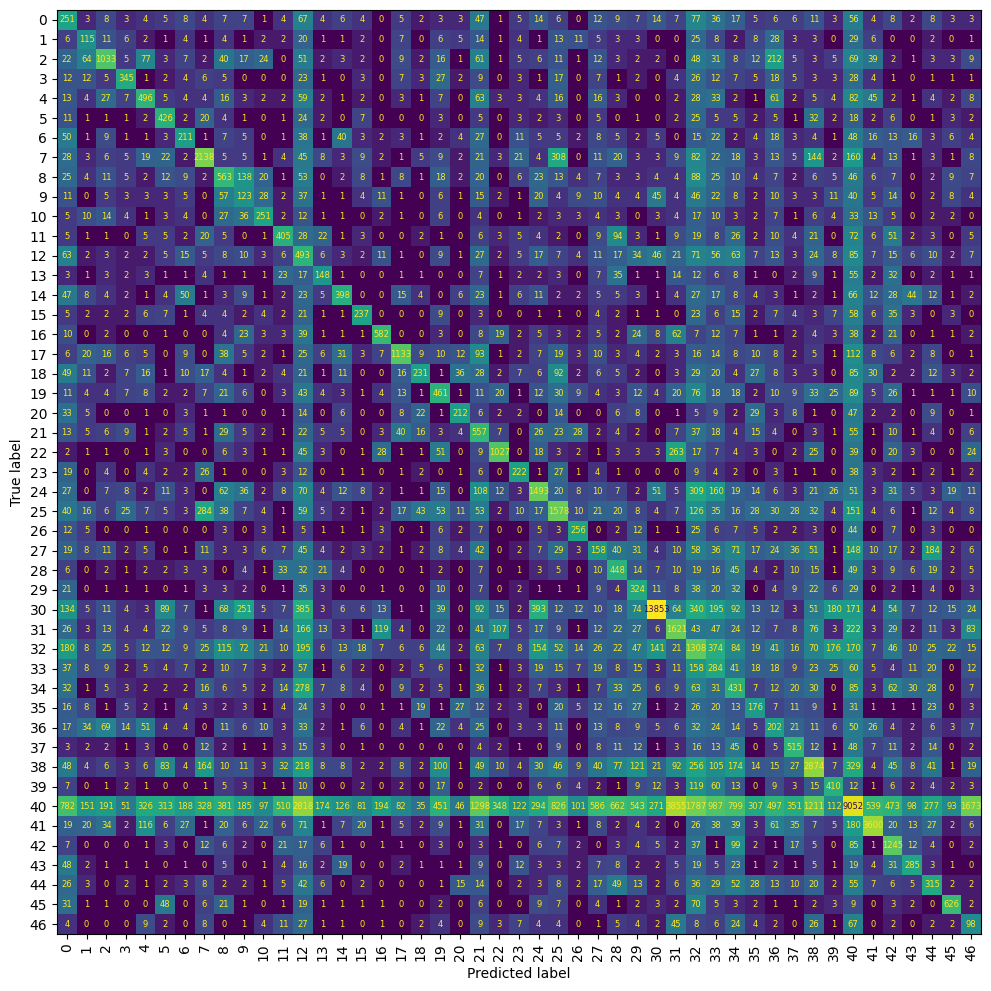

In [22]:
# Calculando a matriz de confusão
conf_matrix = confusion_matrix(y_true, y_pred)
# Criando a exibição da matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix)
plt.rcParams["figure.figsize"] = (15,12)
# Definindo o tamanho da figura
plt.figure(figsize=(15, 12))
# Obtendo a imagem da matriz de confusão com uma escala de cores personalizada
im = disp.plot(cmap='viridis', xticks_rotation='vertical', values_format='d', colorbar=False)

################### Ajustando as cores para a escala logarítmica #################################
im = plt.imshow(conf_matrix, interpolation='nearest', cmap='viridis', norm=LogNorm())
# Adicionando a barra de cores
#plt.colorbar(im)
# Ajustando o tamanho da fonte manualmente
for text in im.axes.texts:
    text.set_fontsize(6)
# Exibindo a figura
plt.show()

In [28]:
print(label_encoder.inverse_transform([12]))
print(label_encoder.inverse_transform([21]))
print(label_encoder.inverse_transform([31]))
print(label_encoder.inverse_transform([32]))
print(label_encoder.inverse_transform([33]))
print(label_encoder.inverse_transform([34]))
print(label_encoder.inverse_transform([38]))
print(label_encoder.inverse_transform([39]))
print(label_encoder.inverse_transform([40]))

['CGU – Controladoria-Geral da União']
['INCRA – Instituto Nacional de Colonização e Reforma Agrária']
['MEC – Ministério da Educação']
['MF - Ministério da Fazenda']
['MGI - Ministério da Gestão e da Inovação em Serviços Públicos']
['MJSP – Ministério da Justiça e Segurança Pública']
['MS – Ministério da Saúde']
['MTE - Ministério do Trabalho e Emprego']
['Outros']


In [29]:
print(label_encoder.inverse_transform([8]))
print(label_encoder.inverse_transform([9]))
print(label_encoder.inverse_transform([10]))

['BACEN – Banco Central do Brasil']
['BB – Banco do Brasil S.A.']
['BNDES – Banco Nacional de Desenvolvimento Econômico e Social']
